In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
############################################
# 1. Load Data and Prepare Fraud/Non-Fraud Tensors
############################################

# Load the preprocessed training data
X_train_df = pd.read_csv("Data/processed/X_train.csv")
y_train_df = pd.read_csv("Data/processed/y_train.csv")

# Assuming the first column indicates fraud (1) versus non-fraud (0)
y_train = y_train_df.iloc[:, 0]

# Create boolean masks
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Separate fraud and non-fraud samples
X_fraud_np = X_train_df.loc[fraud_mask].values
X_nonfraud_np = X_train_df.loc[nonfraud_mask].values

# Convert to torch tensors
X_fraud = torch.tensor(X_fraud_np, dtype=torch.float32)
X_nonfraud = torch.tensor(X_nonfraud_np, dtype=torch.float32)

In [3]:
############################################
# 2. Set Device and Move Tensors to Device
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_fraud = X_fraud.to(device)
X_nonfraud = X_nonfraud.to(device)
print("X_fraud shape:", X_fraud.shape)
print("X_nonfraud shape:", X_nonfraud.shape)

Using device: cuda
X_fraud shape: torch.Size([6273, 19])
X_nonfraud shape: torch.Size([1197782, 19])


In [4]:
############################################
# 3. Diffusion Hyperparameters and Schedule
############################################

T_train = 800  # Number of diffusion steps during training
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)  # shape: (T_train,)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)  # cumulative product for noise schedule

# Loss weights
w1 = 0.2  # probability-based loss weight
w2 = 0.6  # triplet loss weight

In [5]:
############################################
# 4. Define Noise Predictor Model (MLP)
############################################

class NoisePredictor(nn.Module):
    """
    A simple MLP that predicts the noise added at each diffusion step.
    It takes the noised sample (x_t) and a normalized timestep (t) as input.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super(NoisePredictor, self).__init__()
        # Adding 1 to input_dim for the normalized timestep.
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x, t):
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

input_dim = X_fraud.shape[1]  # expected to be 19 features
model = NoisePredictor(input_dim=input_dim, hidden_dim=256).to(device)

In [6]:
input_dim

19

In [7]:
############################################
# 5. Compute Adaptive Non-Fraud Prior (for Loss Computation)
############################################

mu_nf = X_nonfraud.mean(dim=0, keepdim=True).to(device)
sigma_nf = X_nonfraud.std(dim=0, keepdim=True).to(device) + 1e-5  # avoid division by zero

In [8]:
############################################
# 6. Define Helper Functions and Losses
############################################

def forward_diffusion(x0, t):
    """
    Given input x0 and a diffusion step t, compute the noised sample x_t using the closed-form solution.
    """
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)  # tail probability
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

In [9]:
############################################
# 7. Train the Diffusion Model
############################################

batch_size = 40
fraud_dataset = TensorDataset(X_fraud)
loader = DataLoader(fraud_dataset, batch_size=batch_size, shuffle=True)
num_epochs = 150
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training…")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0 = batch[0]  # real fraud samples
        current_batch_size = x0.shape[0]
        t = torch.randint(0, T_train, (current_batch_size,), device=device)
        
        # Forward diffusion step
        x_t, true_noise = forward_diffusion(x0, t)
        pred_noise = model(x_t, t)
        
        L_norm = compute_Lnorm(pred_noise, true_noise)
        L_prior = compute_Lprior(pred_noise)
        
        # Estimate x0 through the reverse process update
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est = (x_t - sqrt_one_minus_alpha_hat_t * pred_noise) / sqrt_alpha_hat_t
        
        # Sample negatives from non-fraud samples for triplet loss
        neg_indices = torch.randint(0, X_nonfraud.shape[0], (current_batch_size,), device=device)
        negative_sample = X_nonfraud[neg_indices]
        L_triplet = triplet_loss(x0_est, x0, negative_sample)
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
    avg_loss = epoch_loss / len(loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
print("Training complete. Saving model as 'fraud_diffuse_model_v2.pth'...")
torch.save(model.state_dict(), "fraud_diffuse_model_v2.pth")
print("Model saved.")

Starting training…
Epoch [1/150], Loss: 5.4599
Epoch [10/150], Loss: 0.8909
Epoch [20/150], Loss: 0.7731
Epoch [30/150], Loss: 0.7080
Epoch [40/150], Loss: 0.6774
Epoch [50/150], Loss: 0.6568
Epoch [60/150], Loss: 0.6606
Epoch [70/150], Loss: 0.6552
Epoch [80/150], Loss: 0.6253
Epoch [90/150], Loss: 0.6249
Epoch [100/150], Loss: 0.6195
Epoch [110/150], Loss: 0.6374
Epoch [120/150], Loss: 0.6074
Epoch [130/150], Loss: 0.6008
Epoch [140/150], Loss: 0.6214
Epoch [150/150], Loss: 0.6153
Training complete. Saving model as 'fraud_diffuse_model_v2.pth'...
Model saved.


In [10]:
############################################
# 8. Reload the Trained Model
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NoisePredictor(input_dim=19, hidden_dim=256).to(device)
model.load_state_dict(torch.load("fraud_diffuse_model_v2.pth", map_location=device))
model.eval()
print("Model reloaded and set to evaluation mode.")

Model reloaded and set to evaluation mode.


In [11]:
############################################
# 9. Generate Synthetic Fraud Samples using Reverse Diffusion
############################################

def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    """
    Generate synthetic fraud samples using the reverse diffusion process.
    Instead of using the non-fraud prior, we initialize x_T using the fraud data's distribution.
    """
    model.eval()
    with torch.no_grad():
        # Use fraud data statistics for initial x_T
        noise = torch.randn(num_samples, X_fraud.shape[1]).to(device)
        x_t = X_fraud.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
              X_fraud.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        # Reverse diffusion process
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t, t)
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t) if t_step > 1 else torch.zeros_like(x_t)
            x_t = (x_t - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise) / sqrt_alpha_t 
            x_t = x_t + torch.sqrt(beta_t) * z
        return x_t

num_synthetic = 100  # desired number of synthetic samples
synthetic_frauds = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic fraud samples shape:", synthetic_frauds.shape)

Synthetic fraud samples shape: torch.Size([100, 19])


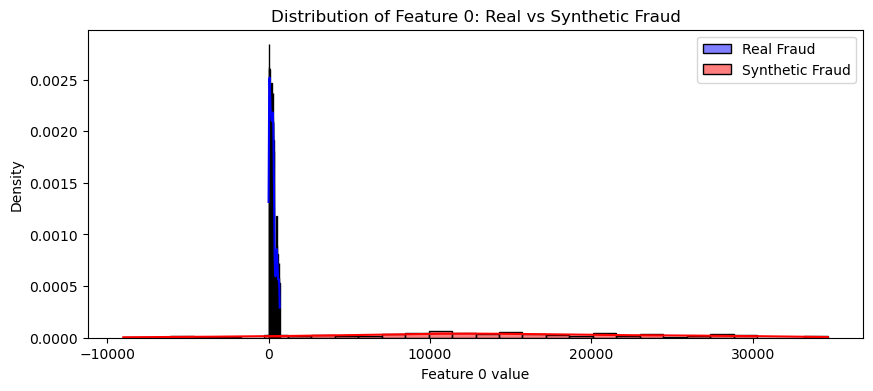

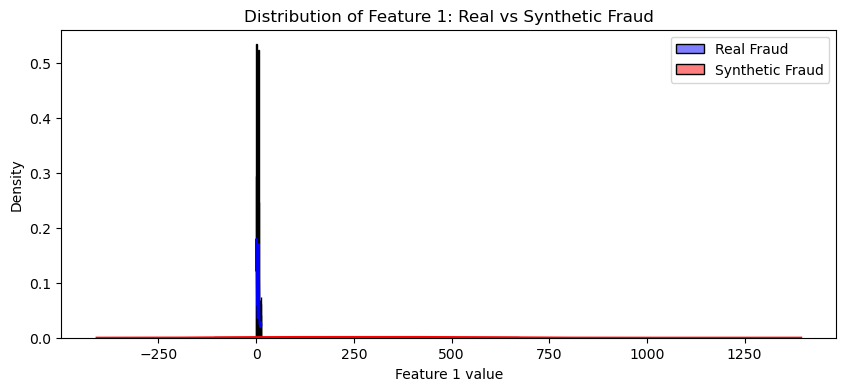

In [12]:
############################################
# 10. Visualization and Descriptive Statistics
############################################

synthetic_np = synthetic_frauds.cpu().numpy()
real_fraud_np = X_fraud.cpu().numpy()

# Plot distributions for a couple of features (0 and 1)
for col in [0, 1]:
    plt.figure(figsize=(10, 4))
    sns.histplot(real_fraud_np[:, col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_np[:, col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of Feature {col}: Real vs Synthetic Fraud")
    plt.xlabel(f"Feature {col} value")
    plt.ylabel("Density")
    plt.show()

In [13]:
# Display descriptive statistics
num_features = real_fraud_np.shape[1]
columns = [f"F{i}" for i in range(num_features)]
real_df = pd.DataFrame(real_fraud_np, columns=columns)
synthetic_df = pd.DataFrame(synthetic_np, columns=columns)

print("Real Fraud Statistics:")
print(real_df.describe())

print("\n" + "="*50 + "\n")

print("Synthetic Fraud Statistics:")
print(synthetic_df.describe())

Real Fraud Statistics:
                F0           F1           F2           F3           F4  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean    242.449066     4.408257     1.569536     0.493863   500.800415   
std     177.679779     3.582832     1.263539     0.500007   286.820953   
min       0.000000     0.000000    -2.180321     0.000000     0.000000   
25%      95.000000     1.000000     1.512012     0.000000   251.000000   
50%     216.000000     4.000000     1.883656     0.000000   503.000000   
75%     330.000000     7.000000     2.539076     1.000000   743.000000   
max     692.000000    13.000000     2.868764     1.000000   998.000000   

                F5          F6           F7           F8           F9  \
count  6273.000000  6273.00000  6273.000000  6273.000000  6273.000000   
mean    439.567047    22.14953   491.675751     0.035681     0.003129   
std     259.891357    13.03732   282.970795     1.006742     1.033924   
min       0.000000

Using device: cuda
X_fraud shape: torch.Size([6273, 19])
X_nonfraud shape: torch.Size([1197782, 19])
Starting training…
Epoch [1/150], Loss: 2.9844
Epoch [10/150], Loss: 0.8501
Epoch [20/150], Loss: 0.7651
Epoch [30/150], Loss: 0.7100
Epoch [40/150], Loss: 0.6697
Epoch [50/150], Loss: 0.6531
Epoch [60/150], Loss: 0.6371
Epoch [70/150], Loss: 0.6417
Epoch [80/150], Loss: 0.6281
Epoch [90/150], Loss: 0.6243
Epoch [100/150], Loss: 0.6425
Epoch [110/150], Loss: 0.6248
Epoch [120/150], Loss: 0.6071
Epoch [130/150], Loss: 0.6154
Epoch [140/150], Loss: 0.6060
Epoch [150/150], Loss: 0.6118
Training complete. Saving model as 'fraud_diffuse_model.pth'...
Model saved.
Model reloaded and set to evaluation mode.
Synthetic fraud samples shape (pre-correction): torch.Size([100, 19])
Corrected Synthetic Fraud Statistics:
               F0          F1          F2          F3           F4  \
count  100.000000  100.000000  100.000000  100.000000   100.000000   
mean   242.449020    4.408257    1.569536  

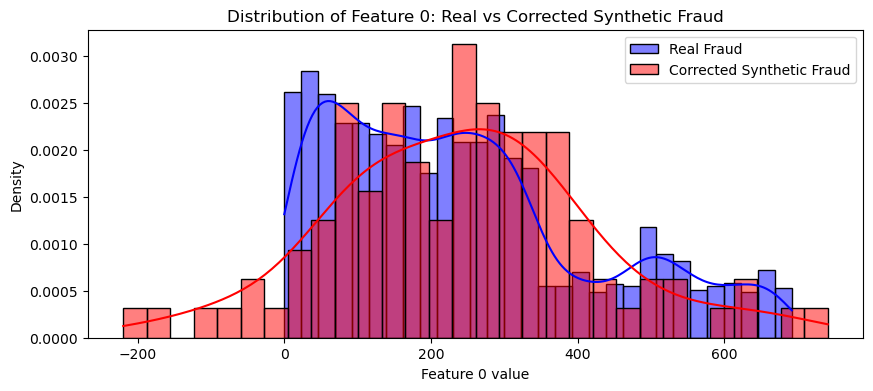

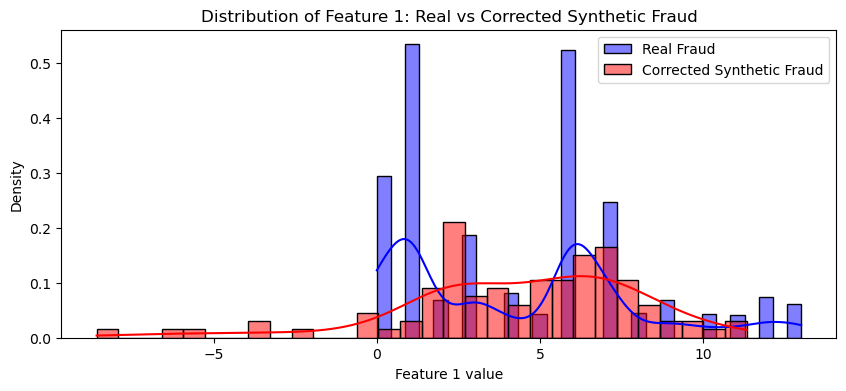

Real Fraud Statistics:
                F0           F1           F2           F3           F4  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean    242.449066     4.408257     1.569536     0.493863   500.800415   
std     177.679779     3.582832     1.263539     0.500007   286.820953   
min       0.000000     0.000000    -2.180321     0.000000     0.000000   
25%      95.000000     1.000000     1.512012     0.000000   251.000000   
50%     216.000000     4.000000     1.883656     0.000000   503.000000   
75%     330.000000     7.000000     2.539076     1.000000   743.000000   
max     692.000000    13.000000     2.868764     1.000000   998.000000   

                F5          F6           F7           F8           F9  \
count  6273.000000  6273.00000  6273.000000  6273.000000  6273.000000   
mean    439.567047    22.14953   491.675751     0.035681     0.003129   
std     259.891357    13.03732   282.970795     1.006742     1.033924   
min       0.000000

In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

############################################
# 1. Load Data and Prepare Fraud/Non-Fraud Tensors
############################################

# Load the preprocessed training data
X_train_df = pd.read_csv("Data/processed/X_train.csv")
y_train_df = pd.read_csv("Data/processed/y_train.csv")

# Assuming the first column of y_train_df indicates fraud (1) vs non-fraud (0)
y_train = y_train_df.iloc[:, 0]

# Create boolean masks
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Separate fraud and non-fraud samples
X_fraud_np = X_train_df.loc[fraud_mask].values
X_nonfraud_np = X_train_df.loc[nonfraud_mask].values

# Convert to torch tensors
X_fraud = torch.tensor(X_fraud_np, dtype=torch.float32)
X_nonfraud = torch.tensor(X_nonfraud_np, dtype=torch.float32)

############################################
# 2. Set Device and Move Tensors to Device
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_fraud = X_fraud.to(device)
X_nonfraud = X_nonfraud.to(device)
print("X_fraud shape:", X_fraud.shape)
print("X_nonfraud shape:", X_nonfraud.shape)

############################################
# 3. Diffusion Hyperparameters and Schedule
############################################

T_train = 800  # Number of diffusion steps during training
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)  # shape: (T_train,)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)  # cumulative product for noise schedule

# Loss weights
w1 = 0.2  # probability-based loss weight
w2 = 0.6  # triplet loss weight

############################################
# 4. Define Noise Predictor Model (MLP)
############################################

class NoisePredictor(nn.Module):
    """
    A simple MLP that predicts the noise added at each diffusion step.
    It takes the noised sample (x_t) and a normalized timestep (t) as input.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super(NoisePredictor, self).__init__()
        # Adding 1 to input_dim for the normalized timestep
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x, t):
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

input_dim = X_fraud.shape[1]  # expected to be 19 features
model = NoisePredictor(input_dim=input_dim, hidden_dim=256).to(device)

############################################
# 5. Compute Adaptive Non-Fraud Prior (for Loss Computation)
############################################

mu_nf = X_nonfraud.mean(dim=0, keepdim=True).to(device)
sigma_nf = X_nonfraud.std(dim=0, keepdim=True).to(device) + 1e-5  # avoid division by zero

############################################
# 6. Define Helper Functions and Losses
############################################

def forward_diffusion(x0, t):
    """
    Given input x0 and a diffusion step t, compute the noised sample x_t using the closed-form solution.
    """
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)  # tail probability
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

############################################
# 7. Train the Diffusion Model
############################################

batch_size = 40
fraud_dataset = TensorDataset(X_fraud)
loader = DataLoader(fraud_dataset, batch_size=batch_size, shuffle=True)
num_epochs = 150  # You might try increasing this to improve quality
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training…")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0 = batch[0]  # real fraud samples
        current_batch_size = x0.shape[0]
        t = torch.randint(0, T_train, (current_batch_size,), device=device)
        
        # Forward diffusion step
        x_t, true_noise = forward_diffusion(x0, t)
        pred_noise = model(x_t, t)
        
        L_norm = compute_Lnorm(pred_noise, true_noise)
        L_prior = compute_Lprior(pred_noise)
        
        # Estimate x0 from the reverse update (one-step reverse estimation)
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est = (x_t - sqrt_one_minus_alpha_hat_t * pred_noise) / sqrt_alpha_hat_t
        
        # Sample negatives from the non-fraud samples for triplet loss
        neg_indices = torch.randint(0, X_nonfraud.shape[0], (current_batch_size,), device=device)
        negative_sample = X_nonfraud[neg_indices]
        L_triplet = triplet_loss(x0_est, x0, negative_sample)
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
    avg_loss = epoch_loss / len(loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
print("Training complete. Saving model as 'fraud_diffuse_model.pth'...")
torch.save(model.state_dict(), "fraud_diffuse_model_v3.pth")
print("Model saved.")

############################################
# 8. Reload the Trained Model
############################################

model = NoisePredictor(input_dim=19, hidden_dim=256).to(device)
model.load_state_dict(torch.load("fraud_diffuse_model_v3.pth", map_location=device))
model.eval()
print("Model reloaded and set to evaluation mode.")

############################################
# 9. Generate Synthetic Fraud Samples using Reverse Diffusion
############################################

def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    """
    Generate synthetic fraud samples using the reverse diffusion process.
    Instead of using the non-fraud prior, we initialize x_T using the fraud data's distribution.
    """
    model.eval()
    with torch.no_grad():
        # Use fraud data statistics for initial x_T
        noise = torch.randn(num_samples, X_fraud.shape[1]).to(device)
        x_t = X_fraud.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
              X_fraud.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        # Reverse diffusion process
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t, t)
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t) if t_step > 1 else torch.zeros_like(x_t)
            # Reverse update according to DDPM update rule
            x_t = (x_t - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise) / sqrt_alpha_t + torch.sqrt(beta_t) * z
        return x_t

num_synthetic = 100  # desired number of synthetic samples
synthetic_frauds = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic fraud samples shape (pre-correction):", synthetic_frauds.shape)

############################################
# 10. Post-Hoc Scaling Correction
############################################
# Our synthetic data statistics appear to be off in scale relative to the real fraud data.
# As a temporary fix, we can scale each feature of the synthetic samples to have the same mean and std as the real fraud data.

# Convert tensors to NumPy arrays
synthetic_np = synthetic_frauds.cpu().numpy()
real_np = X_fraud.cpu().numpy()

# Create DataFrames for easier manipulation
columns = [f"F{i}" for i in range(X_fraud.shape[1])]
synthetic_df = pd.DataFrame(synthetic_np, columns=columns)
real_df = pd.DataFrame(real_np, columns=columns)

# Apply per-feature scaling correction:
corrected_synthetic_df = synthetic_df.copy()
for col in columns:
    syn_mean = synthetic_df[col].mean()
    syn_std = synthetic_df[col].std()
    real_mean = real_df[col].mean()
    real_std = real_df[col].std()
    # Scale synthetic data to have the same mean and std as the real data
    corrected_synthetic_df[col] = (synthetic_df[col] - syn_mean) * (real_std / syn_std) + real_mean

print("Corrected Synthetic Fraud Statistics:")
print(corrected_synthetic_df.describe())

############################################
# 11. Visualization of Real vs Corrected Synthetic Data
############################################

real_np = real_df.values  # real fraud data from training set
corrected_synthetic_np = corrected_synthetic_df.values

for col in [0, 1]:  # Change or add as needed for more features
    plt.figure(figsize=(10, 4))
    sns.histplot(real_np[:, col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(corrected_synthetic_np[:, col], color='red', label='Corrected Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of Feature {col}: Real vs Corrected Synthetic Fraud")
    plt.xlabel(f"Feature {col} value")
    plt.ylabel("Density")
    plt.show()

############################################
# 12. Print Descriptive Statistics for Comparison
############################################

print("Real Fraud Statistics:")
print(real_df.describe())
print("\n" + "="*50 + "\n")
print("Corrected Synthetic Fraud Statistics:")
print(corrected_synthetic_df.describe())